In [ ]:
!pip install statsmodels --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.8 MB 5.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from sklearn import metrics
import time
from datetime import timedelta, date, datetime

In [2]:
from google.colab import files
import io
uploaded = files.upload()

Saving Global DataBase3.csv to Global DataBase3.csv


In [3]:
#read dataframe from DB
df=pd.read_csv(io.BytesIO(uploaded['Global DataBase3.csv']), index_col='datetime', parse_dates=True, dayfirst = True)

df = df.sort_index()
df = df.loc['2017-01-01':'2020-12-31']
#Handeling global outliers
GlobalOutliers =  []
for i in range():
    GlobalOutliers.append(df.idxmax()['Price - PT [€/MWh]'])
    df.at[df.idxmax()['Price - PT [€/MWh]'], 'Price - PT [€/MWh]'] = np.nan

#Replacing them with the mean of that day
for d in GlobalOutliers:
    sdt = datetime.combine(d, datetime.min.time())
    edt = sdt + timedelta(hours=24)
    df.at[d, 'Price - PT [€/MWh]'] = df[sdt:edt]['Price - PT [€/MWh]'].mean()
    
    
#Handling negative values 
negativeIndex = df.index[df['Price - PT [€/MWh]'] < 0]
for index in (negativeIndex):
    df.at[index, 'Price - PT [€/MWh]']= df.at[index - timedelta(hours=1), 'Price - PT [€/MWh]']

df = df.dropna()

In [4]:
df_u=df['Price - PT [€/MWh]'].dropna()

In [ ]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_u)#, autolag= 'AIC'

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
train = df_u

In [ ]:
result = adfuller(train)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

In [ ]:
# split into train and test sets 
size = int(len(df_u) * 0.95)
train, test = df_u[0:size], df_u[size:len(df_u)]

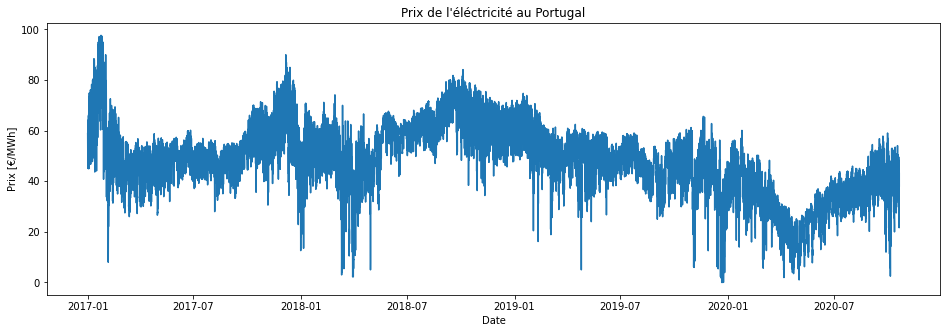

In [ ]:
plt.figure(figsize=(16,5))
plt.gca().set(title="Prix de l'éléctricité au Portugal", xlabel='Date', ylabel='Prix [€/MWh]')
plt.plot(train.index, train)  
plt.show()

In [ ]:
#Grid search to find ARIMA params (p, d, q)
import warnings # supress warnings
warnings.filterwarnings('ignore')
import itertools
#set parameter range
p = range(0,7)
q = range(0,3)
d = range(0,3)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
print(pdq)

#ARIMA model pipeline
tab_param=[]
tab_aic=[]
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(train,order=param)
        results = mod.fit()
        print(result)
        print('ARIMA{} - AIC:{}'.format(param, results.aic))
    except:
        pass

    tab_param.append(param)
    tab_aic.append(results.aic)

param_tunning_df= pd.DataFrame({'param': tab_param, 'aic':tab_aic })

param_tunning_df.loc[param_tunning_df['aic'].idxmin()]['param']

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 2, 0), (6, 2, 1), (6, 2, 2)]
(-7.6492064593393545, 1.8081426412456946e-11, 51, 35011, {'1%': -3.43053679213716, '5%': -2.8616225575095284, '10%': -2.566813942767471}, 154965.2634029787)
ARIMA(0, 0, 0) - AIC:272908.6584772084
(-7.6492064593393545, 1.8081426412456946e-11, 51, 35011, {'1%': -3.43053679213716, '5%': -2.8616225575095284, 

(2, 1, 2)

In [ ]:
#hourly 6, 0, 1
from statsmodels.tsa.arima.model import ARIMA

history = [x for x in train]
predictions = list()

start_time = time.time()

# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(6, 0, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
# evaluate forecasts

exec_time = time.time() - start_time

predicted=185.177384, expected=205.000000
predicted=203.202342, expected=185.680000
predicted=180.713209, expected=179.640000
predicted=175.972155, expected=169.120000
predicted=167.709041, expected=165.000000
predicted=164.321577, expected=184.190000
predicted=187.869206, expected=178.690000
predicted=178.769289, expected=172.440000
predicted=171.416799, expected=163.180000
predicted=162.657384, expected=159.870000
predicted=159.713489, expected=165.500000
predicted=167.224879, expected=185.360000
predicted=188.545374, expected=205.790000
predicted=207.727329, expected=211.050000
predicted=208.832181, expected=204.000000
predicted=198.689319, expected=197.790000
predicted=192.233649, expected=187.960000
predicted=182.533368, expected=187.320000
predicted=184.164788, expected=185.530000
predicted=183.680088, expected=184.860000
predicted=183.622383, expected=181.390000
predicted=180.473318, expected=185.090000
predicted=185.108326, expected=190.000000
predicted=190.188274, expected=206

predicted=276.891507, expected=305.860000
predicted=308.584440, expected=317.580000
predicted=318.072574, expected=315.860000
predicted=311.861496, expected=324.230000
predicted=321.064513, expected=325.000000
predicted=319.785611, expected=323.830000
predicted=317.776175, expected=319.090000
predicted=313.457600, expected=321.000000
predicted=316.633387, expected=321.000000
predicted=317.127043, expected=317.020000
predicted=312.927963, expected=319.320000
predicted=316.679909, expected=332.990000
predicted=331.957475, expected=344.140000
predicted=342.113083, expected=349.410000
predicted=345.583849, expected=350.000000
predicted=344.943443, expected=343.100000
predicted=336.742735, expected=328.000000
predicted=321.128255, expected=322.420000
predicted=318.204161, expected=335.620000
predicted=335.220948, expected=318.510000
predicted=314.678986, expected=367.750000
predicted=371.971194, expected=350.000000
predicted=345.854486, expected=325.350000
predicted=316.781094, expected=319

predicted=215.424784, expected=207.100000
predicted=208.023903, expected=196.050000
predicted=186.448846, expected=169.420000
predicted=159.602368, expected=133.740000
predicted=122.293147, expected=113.050000
predicted=107.803980, expected=105.140000
predicted=105.841910, expected=52.640000
predicted=50.929830, expected=3.570000
predicted=5.745347, expected=2.670000
predicted=16.204836, expected=2.670000
predicted=18.047760, expected=2.670000
predicted=17.481478, expected=2.670000
predicted=17.092256, expected=7.500000
predicted=20.102519, expected=104.900000
predicted=125.936282, expected=120.000000
predicted=125.449077, expected=153.340000
predicted=151.743341, expected=20.000000
predicted=-1.661699, expected=64.700000
predicted=62.024524, expected=103.560000
predicted=111.428905, expected=122.610000
predicted=118.709023, expected=143.450000
predicted=143.143569, expected=142.410000
predicted=136.129907, expected=135.710000
predicted=126.551537, expected=127.550000
predicted=119.351

predicted=224.406531, expected=220.250000
predicted=217.039769, expected=216.350000
predicted=212.823449, expected=213.930000
predicted=211.348523, expected=213.930000
predicted=212.155751, expected=213.750000
predicted=212.514526, expected=213.890000
predicted=212.858275, expected=220.140000
predicted=219.898830, expected=229.570000
predicted=229.379215, expected=259.450000
predicted=260.581619, expected=262.950000
predicted=259.347241, expected=252.460000
predicted=244.822990, expected=200.340000
predicted=189.202135, expected=209.070000
predicted=207.184945, expected=225.610000
predicted=228.853129, expected=233.650000
predicted=233.574269, expected=235.010000
predicted=234.840012, expected=225.610000
predicted=223.259502, expected=216.680000
predicted=214.101784, expected=205.960000
predicted=204.161138, expected=205.000000
predicted=205.229221, expected=199.960000
predicted=200.783843, expected=196.420000
predicted=197.527740, expected=192.770000
predicted=194.534955, expected=192

predicted=203.720171, expected=201.700000
predicted=195.756667, expected=184.860000
predicted=179.045004, expected=180.000000
predicted=177.366175, expected=162.970000
predicted=160.986970, expected=159.500000
predicted=160.123247, expected=154.700000
predicted=157.191162, expected=154.700000
predicted=157.552755, expected=192.890000
predicted=200.457578, expected=175.000000
predicted=174.067989, expected=168.460000
predicted=166.076084, expected=166.900000
predicted=167.840418, expected=167.000000
predicted=166.634668, expected=168.000000
predicted=168.411329, expected=169.940000
predicted=170.477078, expected=169.940000
predicted=169.991413, expected=168.980000
predicted=168.649979, expected=182.300000
predicted=183.500305, expected=188.290000
predicted=188.010118, expected=184.000000
predicted=181.126262, expected=184.390000
predicted=182.227069, expected=191.050000
predicted=189.741357, expected=189.990000
predicted=187.361063, expected=191.500000
predicted=189.042261, expected=193

predicted=233.576007, expected=236.020000
predicted=232.929681, expected=220.870000
predicted=216.292229, expected=217.410000
predicted=214.509229, expected=218.000000
predicted=217.434877, expected=229.000000
predicted=229.533166, expected=223.530000
predicted=222.130156, expected=231.200000
predicted=230.628496, expected=234.890000
predicted=234.278756, expected=221.860000
predicted=217.990899, expected=214.010000
predicted=211.556285, expected=209.030000
predicted=208.320563, expected=220.000000
predicted=221.502746, expected=229.000000
predicted=230.389178, expected=261.500000
predicted=264.094338, expected=263.390000
predicted=260.646675, expected=268.650000
predicted=263.258373, expected=266.010000
predicted=260.341364, expected=257.550000
predicted=250.301919, expected=250.940000
predicted=245.328044, expected=234.500000
predicted=229.173205, expected=220.580000
predicted=217.187376, expected=216.000000
predicted=216.106293, expected=207.630000
predicted=208.487677, expected=206

predicted=228.959178, expected=236.730000
predicted=238.659731, expected=226.300000
predicted=219.881863, expected=210.060000
predicted=206.222971, expected=172.000000
predicted=165.631052, expected=171.900000
predicted=172.689011, expected=162.300000
predicted=165.311153, expected=158.720000
predicted=162.141697, expected=151.580000
predicted=156.488232, expected=150.600000
predicted=155.739057, expected=152.050000
predicted=157.578772, expected=163.480000
predicted=169.265313, expected=213.510000
predicted=222.481479, expected=219.630000
predicted=219.584552, expected=215.280000
predicted=209.407991, expected=175.130000
predicted=165.971643, expected=162.200000
predicted=157.156157, expected=165.000000
predicted=166.101104, expected=155.200000
predicted=155.106076, expected=143.250000
predicted=144.296181, expected=138.170000
predicted=141.588411, expected=135.390000
predicted=139.401388, expected=160.840000
predicted=168.091809, expected=210.930000
predicted=219.629551, expected=150

predicted=216.652427, expected=234.490000
predicted=232.587215, expected=220.090000
predicted=213.796842, expected=213.910000
predicted=208.220014, expected=212.010000
predicted=209.006831, expected=210.670000
predicted=207.939281, expected=208.120000
predicted=206.139548, expected=210.000000
predicted=209.059957, expected=195.000000
predicted=192.417092, expected=178.300000
predicted=176.138435, expected=190.100000
predicted=193.346872, expected=203.790000
predicted=207.508271, expected=220.360000
predicted=222.454680, expected=215.740000
predicted=213.956283, expected=210.400000
predicted=207.107748, expected=194.430000
predicted=190.695164, expected=163.710000
predicted=159.187596, expected=210.610000
predicted=217.814775, expected=208.120000
predicted=209.861665, expected=200.390000
predicted=197.080811, expected=273.560000
predicted=281.575266, expected=268.990000
predicted=263.757425, expected=230.000000
predicted=215.234873, expected=193.160000
predicted=183.469323, expected=179

predicted=308.300420, expected=305.910000
predicted=298.016099, expected=214.500000
predicted=201.762881, expected=211.420000
predicted=214.906060, expected=207.000000
predicted=218.978679, expected=189.310000
predicted=198.296360, expected=190.510000
predicted=203.705924, expected=200.000000
predicted=213.540232, expected=213.690000
predicted=225.094816, expected=215.000000
predicted=222.520492, expected=214.900000
predicted=219.717673, expected=250.000000
predicted=257.229730, expected=220.670000
predicted=218.533274, expected=215.000000
predicted=213.135344, expected=215.300000
predicted=217.242710, expected=252.950000
predicted=257.505445, expected=292.340000
predicted=295.905536, expected=288.330000
predicted=282.215434, expected=280.980000
predicted=272.026697, expected=258.000000
predicted=248.325740, expected=221.100000
predicted=211.463177, expected=215.300000
predicted=213.506205, expected=214.800000
predicted=217.317476, expected=214.480000
predicted=217.514750, expected=214

predicted=401.418231, expected=409.300000
predicted=400.485326, expected=400.000000
predicted=388.221500, expected=390.510000
predicted=379.200052, expected=382.110000
predicted=373.018563, expected=365.040000
predicted=357.191532, expected=376.500000
predicted=374.094091, expected=360.000000
predicted=356.172836, expected=350.000000
predicted=346.874415, expected=330.000000
predicted=328.196456, expected=338.850000
predicted=341.333309, expected=347.040000
predicted=350.734670, expected=219.420000
predicted=207.328528, expected=220.000000
predicted=226.580282, expected=214.900000
predicted=230.660655, expected=207.900000
predicted=220.986983, expected=205.000000
predicted=219.861758, expected=204.430000
predicted=217.783430, expected=196.840000
predicted=207.655699, expected=189.890000
predicted=199.398002, expected=202.170000
predicted=213.035908, expected=222.310000
predicted=232.480862, expected=273.440000
predicted=283.741903, expected=278.360000
predicted=278.964049, expected=251

predicted=173.905024, expected=180.010000
predicted=184.655883, expected=183.620000
predicted=186.816621, expected=190.740000
predicted=192.965120, expected=240.110000
predicted=245.502922, expected=250.000000
predicted=247.627317, expected=233.590000
predicted=224.835174, expected=211.500000
predicted=203.036661, expected=449.600000
predicted=468.528563, expected=514.310000
predicted=504.181791, expected=603.080000
predicted=578.661682, expected=514.352632
predicted=468.110569, expected=514.352632
predicted=473.732664, expected=514.352632
predicted=486.312269, expected=514.352632
predicted=487.253698, expected=514.352632
predicted=494.399013, expected=600.000000
predicted=592.829833, expected=450.950000
predicted=416.940462, expected=449.500000
predicted=433.415068, expected=449.500000
predicted=448.805951, expected=424.880000
predicted=417.878264, expected=429.890000
predicted=431.636968, expected=449.600000
predicted=454.081547, expected=550.000000
predicted=560.463432, expected=600

predicted=195.540378, expected=194.900000
predicted=197.728016, expected=204.450000
predicted=207.762665, expected=219.320000
predicted=222.001555, expected=221.310000
predicted=220.921425, expected=216.000000
predicted=213.299141, expected=205.790000
predicted=202.397535, expected=197.890000
predicted=195.229919, expected=199.030000
predicted=198.530293, expected=178.850000
predicted=176.919634, expected=175.050000
predicted=175.615103, expected=167.200000
predicted=168.961790, expected=165.000000
predicted=167.131576, expected=171.300000
predicted=175.030217, expected=196.950000
predicted=201.778634, expected=220.040000
predicted=222.640738, expected=229.700000
predicted=227.684504, expected=223.920000
predicted=218.140598, expected=207.830000
predicted=200.263065, expected=191.500000
predicted=185.181849, expected=174.950000
predicted=171.052463, expected=174.500000
predicted=174.803804, expected=174.550000
predicted=176.663778, expected=172.540000
predicted=174.458437, expected=176

In [ ]:
print('Mean Squared Error:', metrics.mean_squared_error(test, predictions))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(test, predictions)))
print('Mean Absolute Error:', metrics.mean_absolute_error(test, predictions))
print('Coefficient of Variance:', (np.sqrt(metrics.mean_squared_error(test, predictions))/test.mean())*100)
print('Execution Time:', '%.5f' %  exec_time)

Mean Squared Error: 772.3011170156361
Root Mean Squared Error: 27.790306169879383
Mean Absolute Error: 15.072461554165496
Coefficient of Variance: 11.84561927929956
Execution Time: 121331.54100
